In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
import torch.utils.data as datautils

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()

## Preparing for data

In [4]:
from google.colab import files
print('Upload kaggle.json')
files.upload()

!cp kaggle.json /root/.kaggle/
!kaggle competitions download -c digit-recognizer
!ls

Upload kaggle.json


Saving kaggle.json to kaggle.json
 81% 59.0M/73.2M [00:00<00:00, 48.4MB/s]
100% 73.2M/73.2M [00:00<00:00, 79.4MB/s]
 84% 41.0M/48.8M [00:01<00:00, 19.2MB/s]
100% 48.8M/48.8M [00:01<00:00, 32.6MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 56.7MB/s]
kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


In [44]:
train = pd.read_csv('./train.csv')
train.head() 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
image_numpy = train.loc[:, train.columns != 'label'].values / 255 # normalization
label_numpy = train.label.values

In [0]:
image_train, image_test, label_train, label_test = train_test_split(image_numpy, label_numpy, test_size = 0.2, random_state = 42)

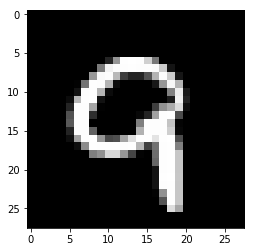

In [54]:
plt.imshow(image_train[10].reshape(28, 28), cmap='gray')

In [0]:
image_train = torch.from_numpy(image_train).float()
label_train = torch.from_numpy(label_train).type(torch.LongTensor)

image_test = torch.from_numpy(image_test).float()
label_test = torch.from_numpy(label_test).type(torch.LongTensor)

In [0]:
train_set = datautils.TensorDataset(image_train, label_train)
test_set = datautils.TensorDataset(image_test, label_test)

train_loader = datautils.DataLoader(train_set, batch_size = 100, shuffle = False)
test_loader = datautils.DataLoader(test_set, batch_size = 100, shuffle = False)                       

In [57]:
print(image_train.shape)

torch.Size([33600, 784])


## Building model

In [0]:
class LogisticRegression(nn.Module):
    def __init__(self, in_size, out_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
        
        if cuda:
            self.linear = self.linear.cuda()
        
    def forward(self, x):
        out = self.linear(x)
        return x

## Training

In [0]:
in_size = 28 * 28
out_size = 1

net = LogisticRegression(in_size, out_size)
get_loss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [62]:
from torch.autograd import Variable

batch_size = 100
n_iter = 1
n_epoch = 10 #int(n_iter * (image_train.shape[0] / batch_size))
loss_graph = []

for epoch in range(n_epoch):
    print('Epoch : {}'.format(epoch))
    for x, label in train_loader:
        x = Variable(x, requires_grad = True)
        
        if cuda:
            x = x.cuda()
            label = label.cuda()
            
        optimizer.zero_grad()
        out = net(x)
        loss = get_loss(out, label)
        loss.backward()
        optimizer.step()
        loss_graph.append(loss.data)
    print('Last Loss : {}'.format(loss_graph[-1]))

Epoch : 0
Last Loss : 6.850248336791992
Epoch : 1
Last Loss : 6.850248336791992
Epoch : 2
Last Loss : 6.850248336791992
Epoch : 3
Last Loss : 6.850248336791992
Epoch : 4
Last Loss : 6.850248336791992
Epoch : 5
Last Loss : 6.850248336791992
Epoch : 6
Last Loss : 6.850248336791992
Epoch : 7
Last Loss : 6.850248336791992
Epoch : 8
Last Loss : 6.850248336791992
Epoch : 9
Last Loss : 6.850248336791992


In [63]:
len(loss_graph)

3360

## Accuracy estimation

In [68]:
total = 0
correct = 0

for x, label in test_loader:
    with torch.no_grad():
        x = Variable(x, requires_grad = True)
        
        if cuda:
            x = x.cuda()
            label = label.cuda()
        
        out = net(x)
        predicted = torch.max(out.data, 1)[1]
        print(predicted)
        total += x.shape[0]
        correct += (predicted == label).sum()

tensor([128, 155, 210, 240, 656, 129, 410, 407, 215, 517, 233, 581, 574, 549,
        661, 237, 350, 100, 544, 630, 384, 345, 208, 436, 154, 481, 131, 658,
         71, 124, 240,  72, 433, 208, 273, 576, 204, 155, 128, 600, 632, 327,
        183, 546, 157, 151, 260, 176, 408, 435, 435, 176, 405, 240, 407, 156,
        575,  71, 658, 352, 352, 271, 432, 128, 550, 148, 272, 176, 630, 128,
        184, 356,  99, 160, 213,  66, 156, 211, 412, 126, 351, 491, 456, 186,
        545, 158, 273, 434, 627, 209, 433, 656, 214, 384, 347, 511, 568, 214,
        152, 381], device='cuda:0')
tensor([384, 515, 245, 435, 461, 265, 209, 241, 156, 317, 133, 160, 274, 210,
        153, 481, 127, 525, 208, 125, 239, 214, 212, 624, 186, 572, 658, 356,
        656, 132, 153, 159,  99, 468, 239, 457, 320, 463, 289, 368, 520, 578,
        380, 260, 603, 207, 184, 267, 245, 684, 160,  99, 154, 627, 244, 100,
        382, 155, 202, 210, 211, 126, 178, 463, 409, 124, 406, 514, 369, 151,
        275, 350, 356, 206, 

In [66]:
print(total, correct)

8400 tensor(0, device='cuda:0')
